In [1]:
import ampal
import isambard
import isambard.specifications as specifications
import isambard.modelling as modelling
import isambard.optimisation as optimisation
import isambard.optimisation.evo_optimizers as ev_opts
from isambard.optimisation.evo_optimizers import Parameter
import budeff

import matplotlib.pyplot as plt
import numpy as np
import itertools
from pprint import pprint
import nglview as nv
from contextlib import redirect_stdout

%matplotlib inline

In [2]:
def show_ball_and_stick(ampal):
    view = nv.show_text(ampal.pdb)
    view.add_ball_and_stick()
    view.remove_cartoon()
    return view

In [3]:
class APHomoDimer(specifications.CoiledCoil):
    """Specification for creating anti-parallel, homodimeric coiled coils."""
    
    oligomeric_state = 2
    
    # The only thing that we need to define is a new `__init__` method, which defines
    # how the class is created. We get all the rest of the functionality off the
    # parent class `CoiledCoil`.
    def __init__(self, helix_length, radius, pitch, phica, zshift):
        # To kick everything off, this class runs the standard setup of the `CoiledCoil`
        # class, which gives our class all of the same attributes and methods. The
        # `super` function gives us access to the parent class. As we want to modify
        # some of the parameters before building the model, we set `auto_build` to false
        super().__init__(self.oligomeric_state, auto_build=False)
        
        # Next, we redefine the relevant default values that `CoiledCoil` has set. As
        # we have 2 helices, we have 2 values for each of these, but in this case they
        # are the same as we're making a homodimer
        self.aas = [helix_length, helix_length]
        self.major_radii = [radius, radius]
        self.major_pitches = [pitch, pitch]
        self.z_shifts = [0, zshift]
        self.phi_c_alphas = [phica, phica]
        
        # We need to set the orientation of the helices to be anti-parallel, so one
        # needs to have a +1 orientation and the other needs a -1 orientation
        self.orientations = [1, -1]

        # Now we've redefined these values, we need to build the model from these
        # parameters. We can do this using the build method, which comes from
        # `CoiledCoil`
        self.build()

In [4]:
REGISTER_ADJUST = {
    'a': 0,
    'b': 102.8,
    'c': 205.6,
    'd': 308.4,
    'e': 51.4,
    'f': 154.2,
    'g': 257
}

In [5]:
sequences = ['GQLKQRRAALKQRIAALKQRRAALKWQIQG', 'GQLKQRRAALKQRIAALKQRRAALKWQIQG']

In [6]:
def get_bude_total_energy(ampal_object):
    return budeff.get_internal_energy(ampal_object).total_energy

In [7]:
parameters = [
    optimisation.Parameter.static('Helix Length', 30),
    optimisation.Parameter.dynamic('Radius', 5.0, 1.0),
    optimisation.Parameter.dynamic('Pitch', 200, 60),
    optimisation.Parameter.dynamic('PhiCA', REGISTER_ADJUST['c'], 27),
    optimisation.Parameter.dynamic('ZShift', 10, 10),
]

In [8]:
default_values = [x.default_value for x in parameters]
print(default_values)

[30, 5.0, 200, 205.6, 10]


Genetic Algorithm

In [9]:
opt_ga = ev_opts.GA(APHomoDimer, sequences, parameters, get_bude_total_energy)

In [10]:
opt_ga.run_opt(100, 30, cores=8)

gen	evals	avg    	std    	min     	max     
0  	67   	-874.38	23.1617	-928.536	-839.762
1  	62   	-891.471	20.8185	-934.011	-862.746
2  	61   	-902.523	19.3157	-943.407	-871.731
3  	62   	-917.365	15.9132	-955.488	-888.821
4  	79   	-930.258	11.4768	-955.488	-910.65 
5  	77   	-938.444	9.285  	-972.076	-924.215
6  	78   	-944.734	7.03965	-972.076	-933.798
7  	72   	-949.352	5.26608	-972.076	-940.446
8  	69   	-951.377	5.13806	-973.345	-944.389
9  	72   	-953.411	5.30596	-974.536	-946.308
10 	74   	-955.389	6.68472	-976.267	-947.921
11 	60   	-959.736	7.55196	-976.267	-950.085
12 	76   	-967.368	6.79998	-976.411	-955.501
13 	86   	-972.17 	4.38786	-978.023	-961.944
14 	58   	-974.973	1.33015	-978.023	-971.737
15 	63   	-975.622	1.06405	-978.023	-973.687
16 	59   	-976.19 	0.911371	-979.366	-974.849
17 	64   	-976.919	0.85188 	-979.7  	-975.362
18 	72   	-977.231	0.797061	-979.7  	-975.722
19 	84   	-977.987	0.768492	-983.575	-977.098
20 	85   	-978.601	1.00994 	-983.701	-977.764
21 	75 

In [11]:
optimized_model_ga = opt_ga.best_model

In [12]:
budeff.get_internal_energy(optimized_model_ga).total_energy

-994.6589845850682

In [13]:
funnel_data_ga = opt_ga.make_energy_funnel_data()

In [14]:
xs = [x[0] for x in funnel_data_ga]
ys = [x[1] for x in funnel_data_ga]
zs = [x[2] for x in funnel_data_ga]

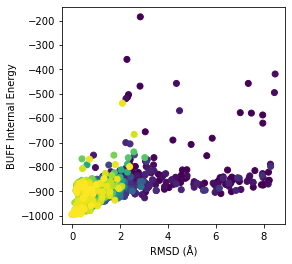

In [15]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(4, 4)
#ax.grid()
ax.scatter(xs, ys, c=zs)
ax.set_xlabel('RMSD (Å)')
ax.set_ylabel('BUFF Internal Energy')

fig.savefig('ga.png')

In [16]:
f = open('apCC-Di-BB_new-optimized-model-ga.pdb', 'w')

with redirect_stdout(f):
    print(optimized_model_ga.pdb)

Differential Evolution

In [17]:
opt_de = ev_opts.DE(APHomoDimer, sequences, parameters, get_bude_total_energy)

/home/eva/anaconda3/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/eva/anaconda3/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [18]:
opt_de.run_opt(100, 30, cores=8)

gen	evals	avg     	std    	min     	max     
0  	100  	-856.641	53.1855	-915.503	-530.258
1  	100  	-878.185	21.7554	-942.373	-809.252
2  	100  	-886.466	21.1561	-942.373	-844.561
3  	100  	-892.879	20.4524	-942.373	-856.338
4  	100  	-900.273	19.7068	-942.373	-859.618
5  	100  	-904.96 	18.5028	-942.373	-871.062
6  	100  	-910.498	18.8963	-954.317	-874.817
7  	100  	-916.301	16.1878	-954.317	-879.14 
8  	100  	-918.8  	15.5468	-954.317	-879.14 
9  	100  	-922.773	14.1248	-954.317	-888.117
10 	100  	-926.182	12.9479	-956.891	-894.666
11 	100  	-928.414	12.451 	-956.891	-894.666
12 	100  	-931.852	10.926 	-956.891	-907.085
13 	100  	-934.829	10.7494	-959.257	-907.085
14 	100  	-937.867	9.57923	-959.257	-912.657
15 	100  	-940.177	9.43398	-969.335	-912.657
16 	100  	-941.683	8.85727	-969.335	-917.632
17 	100  	-943.374	9.53099	-976.544	-919.749
18 	100  	-946.452	8.68803	-976.544	-919.749
19 	100  	-948.251	8.4088 	-976.544	-926.65 
20 	100  	-949.843	8.5356 	-976.544	-926.65 
21 	100  	

In [19]:
optimized_model_de = opt_de.best_model
budeff.get_internal_energy(optimized_model_de).total_energy

-989.2295422963381

In [20]:
funnel_data_de = opt_de.make_energy_funnel_data()

In [21]:
xs = [x[0] for x in funnel_data_de]
ys = [x[1] for x in funnel_data_de]
zs = [x[2] for x in funnel_data_de]

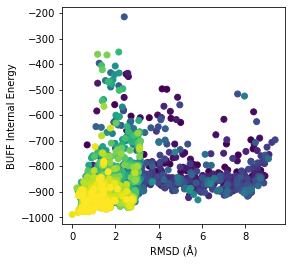

In [22]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(4, 4)
#ax.grid()
ax.scatter(xs, ys, c=zs)
ax.set_xlabel('RMSD (Å)')
ax.set_ylabel('BUFF Internal Energy')

fig.savefig('de.png')

In [23]:
f = open('apCC-Di-BB_new-optimized-model-de.pdb', 'w')

with redirect_stdout(f):
    print(optimized_model_de.pdb)

Particle Swarm Optimisation

In [24]:
opt_pso = ev_opts.PSO(APHomoDimer, sequences, parameters, get_bude_total_energy)

/home/eva/anaconda3/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [25]:
opt_pso.run_opt(100, 30, cores=8)

gen	evals	avg     	std    	min     	max     
0  	100  	-817.839	105.977	-926.142	-359.854
1  	82   	-797.796	159.692	-948.017	-6.55757
2  	80   	-815.668	152.197	-951.216	-6.55757
3  	68   	-850.482	72.7817	-933.192	-410.884
4  	87   	-854.854	68.1135	-941.505	-505.046
5  	87   	-844.456	104.106	-943.646	-292.472
6  	90   	-847.056	100.866	-938.148	15.2467 
7  	88   	-851.946	104.101	-948.239	15.2467 
8  	88   	-827.845	89.5205	-932.472	-313.006
9  	88   	-840.388	81.5772	-935.041	-377.066
10 	82   	-854.667	78.1405	-963.01 	-580.537
11 	85   	-844.883	92.6908	-938.565	-386.904
12 	80   	-848.867	70.1738	-932.646	-538.165
13 	75   	-853.611	59.2432	-951.05 	-538.165
14 	82   	-836.51 	124.617	-961.057	-56.8776
15 	93   	-835.051	118.33 	-943.815	-56.8776
16 	84   	-849.059	80.4521	-944.076	-403.963
17 	89   	-868.869	48.8796	-929.738	-635.085
18 	89   	-852.298	80.1633	-948.387	-475.322
19 	87   	-851.63 	90.0021	-953.506	-475.322
20 	88   	-843.231	94.4137	-958.15 	-312.807
21 	78   	

In [26]:
optimized_model_pso = opt_pso.best_model
budeff.get_internal_energy(optimized_model_pso).total_energy

-963.0101542857076

In [27]:
funnel_data_pso = opt_pso.make_energy_funnel_data()

In [28]:
xs = [x[0] for x in funnel_data_pso]
ys = [x[1] for x in funnel_data_pso]
zs = [x[2] for x in funnel_data_pso]

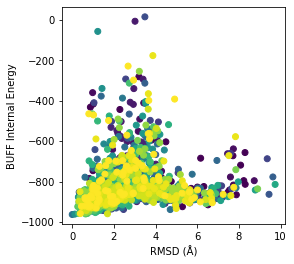

In [29]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(4, 4)
#ax.grid()
ax.scatter(xs, ys, c=zs)
ax.set_xlabel('RMSD (Å)')
ax.set_ylabel('BUFF Internal Energy')

fig.savefig('pso.png')

In [30]:
f = open('apCC-Di-BB_new-optimized-model-pso.pdb', 'w')

with redirect_stdout(f):
    print(optimized_model_pso.pdb)

Covariance Matrix Adaptive Evolutionary Strategy

In [31]:
opt_cmaes = ev_opts.CMAES(APHomoDimer, sequences, parameters, get_bude_total_energy)

/home/eva/anaconda3/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/eva/anaconda3/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [32]:
opt_cmaes.run_opt(100, 30, cores=8)

gen	evals	avg     	std    	min     	max     
0  	100  	-856.568	40.8335	-930.371	-728.242
1  	100  	-861.782	38.2984	-931.721	-748.346
2  	100  	-838.545	111.597	-944.725	-158.882
3  	100  	-857.557	58.4843	-954.694	-638.814
4  	100  	-884.217	42.9771	-941.993	-730.867
5  	100  	-905.595	32.8819	-945.599	-704.435
6  	100  	-915.136	23.0653	-956.493	-813.266
7  	100  	-915.584	24.2824	-953.561	-854.03 
8  	100  	-916.151	35.38  	-959.661	-676.643
9  	100  	-923.138	28.1615	-977.923	-835.127
10 	100  	-921.155	37.1229	-989.704	-767.456
11 	100  	-922.102	40.4598	-986.729	-653.433
12 	100  	-937.199	31.1305	-991.846	-839.691
13 	100  	-939.839	31.1677	-992.232	-848.82 
14 	100  	-950.6  	33.5136	-991.732	-852.062
15 	100  	-947.97 	31.2169	-993.628	-872.817
16 	100  	-952.111	39.3548	-992.989	-813.247
17 	100  	-974.983	22.4633	-993.202	-833.373
18 	100  	-979.302	19.9111	-994.356	-870.547
19 	100  	-985.587	14.1536	-994.613	-881.939
20 	100  	-985.476	11.5001	-994.988	-957.992
21 	100  	

In [33]:
optimized_model_cmaes = opt_cmaes.best_model
budeff.get_internal_energy(optimized_model_cmaes).total_energy

-995.4610734894769

In [34]:
funnel_data_cmaes = opt_cmaes.make_energy_funnel_data()

In [35]:
xs = [x[0] for x in funnel_data_cmaes]
ys = [x[1] for x in funnel_data_cmaes]
zs = [x[2] for x in funnel_data_cmaes]

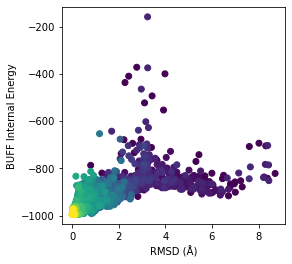

In [36]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(4, 4)
#ax.grid()
ax.scatter(xs, ys, c=zs)
ax.set_xlabel('RMSD (Å)')
ax.set_ylabel('BUFF Internal Energy')

fig.savefig('cmaes.png')

In [37]:
f = open('apCC-Di-BB_new-optimized-model-cmaes.pdb', 'w')

with redirect_stdout(f):
    print(optimized_model_cmaes.pdb)